<a href="https://colab.research.google.com/github/mhask94/cs474_labs_f2019/blob/conv2linear/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports for training data
!if ( ! ls . | grep pytransform ); then git clone https://github.com/mhask94/pytransform.git; fi
# !git clone https://github.com/mhask94/pytransform.git
from pytransform.common import skew
from pytransform.quaternion import Quaternion as Quat
import numpy as np

pytransform


In [0]:
# imports for pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.core.debugger import set_trace

In [0]:
# classes for quadrotor state and dynamics
class State():
    def __init__(self, arr=np.empty(0)):
        if len(arr) == 0:
            self.arr = np.zeros((10,1), dtype=np.float64)
            self.arr[3] = 1
        else:
            assert arr.shape == (10, 1)
            if not arr.dtype == np.float64:
              arr = np.array(arr, dtype=np.float64)
            arr.dtype = np.float64
            self.arr = arr

    def __getitem__(self, position):
        return self.arr[position]
    def __str__(self):
        s = 'p: ' + str(self.p.flatten()) + '\nq: ' + self.q.__str__() + \
                '\nv: ' + str(self.v.flatten())
        s = s.replace('[ ', '[')
        s = s.replace(', ', ' ')
        s = s.replace(' ]', ']')
        return s
    def __repr__(self):
        return self.__str__()
    def __add__(self, other):
        assert other.shape == (9, 1)
        out = np.empty(self.arr.shape)
        out[:3]  = self.p + other[:3]
        out[3:7] = (self.q + other[3:6]).elements
        out[7:]  = self.v + other[6:]
        return State(out)
    def __iadd__(self, other):
        assert other.shape == (9, 1)
        self.arr[:3] += other[:3]
        self.arr[3:7] = (self.q + other[3:6]).elements
        self.arr[7:] += other[6:]
        return self
    @property
    def p(self):
        return self.arr[:3]
    @property
    def q(self):
        return Quat(self.arr[3:7])
    @property
    def v(self):
        return self.arr[7:]
    @property
    def elements(self):
        return self.arr.copy()
    def copy(self):
        return State(self.arr.copy())

class Dynamics():
    def __init__(self):
        self.k1 = np.zeros((9,1))
        self.k2 = np.zeros((9,1))
        self.k3 = np.zeros((9,1))
        self.k4 = np.zeros((9,1))
        self.cd = 0.1
        e_z = np.array([[0,0,1]]).T
        self.g = 9.8065 * e_z
        self.se = 0.5

    def run(self, xu, dt):
        x,u = State(xu[:10]), xu[10:]
        self.k1 = self.f(x, u)
        self.k2 = self.f(x + self.k1*(dt/2), u)
        self.k3 = self.f(x + self.k2*(dt/2), u)
        self.k4 = self.f(x + self.k3*dt, u)
        # x += (self.k1 + 2*(self.k2 + self.k3) + self.k4) * (dt/6)
        return x + (self.k1 + 2*(self.k2 + self.k3) + self.k4) * (dt/6)

    def f(self, x, u):
        s, w = u[0], u[1:]
        dx = np.empty(self.k1.shape)
        dx[:3] = x.q.rota(x.v)
        dx[3:6] = w
        dx[6:] = -self.g*(s/self.se) - self.cd*x.v + x.q.rotp(self.g) - \
                skew(w) @ x.v
        return dx

    @property
    def state(self):
        return self.x.copy()

In [0]:
class DataGenerator():
  def __init__(self, num_states, num_inputs, dt=0.01, batch_size=50):
    self.n = num_states
    self.m = num_inputs
    self.dt = dt
    self.batch_size = batch_size
    self.pos_lim = 50
    self.att_lim = np.pi/3.5
    self.vel_lim = 10
    self.rate_lim = np.pi
    self.s_lim = 1
    self.dyn = Dynamics()

  def getRandomInput(self):
    xu = np.empty(self.n + self.m)
    xu[:2] = np.random.uniform(-self.pos_lim, self.pos_lim, 2)
    xu[2] = np.random.uniform(-self.pos_lim, 0)
    mask = np.random.uniform(size=3) > 0.2
    euler = np.random.uniform(-self.att_lim, self.att_lim, 3) * mask
    xu[3:7] = Quat.from_euler(*euler).elements.flatten()
    xu[7:10] = np.random.uniform(-self.vel_lim, self.vel_lim, 3)
    xu[10] = np.random.uniform(0, self.s_lim)
    xu[11:] = np.random.uniform(-self.rate_lim, self.rate_lim, 3)
    return xu

  def getBatch(self):
    batch_in = np.empty((self.batch_size, self.n+self.m))
    batch_out = np.empty((self.batch_size, self.n))
    for i in range(self.batch_size):
      batch_in[i] = self.getRandomInput()
      batch_out[i] = self.dyn.run(batch_in[i].reshape(-1,1), self.dt).elements.flatten()
    return batch_in, batch_out

In [5]:
def testGen():
  data_gen = DataGenerator(10,4,dt=0.01,batch_size=2)
  ran = data_gen.getRandomInput()
  print('rand: ', ran)

  x, truth = data_gen.getBatch()
  print('x: \n', x)
  print('truth: \n', truth)

  dyn = Dynamics()
  for i, state in enumerate(x):
    state = state.reshape(-1,1)
    out = dyn.run(state, 0.01).elements.flatten()
    error = out - truth[i]
    norm = np.sqrt(error @ error)
    print('norm: ', norm)

testGen()

rand:  [ 2.75936258e+01 -1.73089776e+01 -3.54717030e+01  9.99712791e-01
  0.00000000e+00 -2.39653168e-02  0.00000000e+00  1.22622049e+00
  7.58786927e+00  7.92926085e+00  8.57177888e-01 -2.27884659e+00
 -3.05342169e+00 -1.88735337e+00]
x: 
 [[-1.03185866e+01 -3.87230079e+01 -4.65416270e+01  8.84354899e-01
   1.18946817e-01 -3.88429472e-01 -2.29979591e-01 -1.62669139e+00
  -7.15056905e+00 -7.36212226e+00  7.66513702e-01 -1.88145468e+00
  -4.49874075e-01 -1.35745620e+00]
 [-4.33865105e+01 -1.43136318e+01 -6.40574177e+00  9.04050169e-01
  -1.80586277e-02 -3.19024171e-01 -2.83885112e-01  8.70532583e+00
   9.12577907e+00  9.30118840e+00  8.36135920e-01 -1.01610418e+00
   1.85659858e+00 -7.41482520e-01]]
truth: 
 [[-1.02955505e+01 -3.87744260e+01 -4.66290247e+01  8.82977500e-01
   1.12738359e-01 -3.87420813e-01 -2.39887288e-01 -1.50085163e+00
  -6.98634232e+00 -7.56504179e+00]
 [-4.33355788e+01 -1.42611402e+01 -6.26730090e+00  9.05810570e-01
  -1.88324643e-02 -3.09236695e-01 -2.89007292e-01 

In [6]:
def testLinearSize():
  inputs = 14
  outputs = 10
  batch = 1
  x_test = torch.zeros(batch,inputs)
  up = nn.Linear(inputs, 50)
  up_test = up(x_test)
  print('up: ', up_test.size())

  down = nn.Linear(50, outputs)
  down_test = down(up_test)
  print('down: ', down_test.size())

testLinearSize()

up:  torch.Size([1, 50])
down:  torch.Size([1, 10])


In [0]:
class ResBlock(nn.Module):
  def __init__(self, dim_in, dim_out, skip=False, end_activation=False):
    super(ResBlock, self).__init__()
    self.skip = skip
    self.end_act = end_activation
    self.activation = nn.ReLU()
    self.layer1 = nn.Linear(dim_in, dim_in)
    self.layer2 = nn.Linear(dim_in, dim_in)
    self.layer3 = nn.Linear(dim_in, dim_out)

  def forward(self, x):
    out1 = self.activation(self.layer1(x))
    out2 = self.activation(self.layer2(out1))
    skip = out2 + out1
    if self.end_act:
      out3 = self.activation(self.layer3(skip))
    else:
      out3 = self.layer3(skip)
    if self.skip:
      return skip, out3
    else:
      return out3

class DynamicsNN(nn.Module):
  def __init__(self, num_states, num_inputs, dt):
    super(DynamicsNN, self).__init__()
    self.dt = dt
    self.activation = nn.ReLU()
    self.up1 = nn.Linear(num_states+num_inputs, 100)
    self.up2 = ResBlock(100,  200, skip=True)
    self.up3 = ResBlock(200, 400, skip=True)
    self.dn1 = ResBlock(400, 200)
    self.dn2 = ResBlock(200, 100)
    self.dn3 = ResBlock(100,  num_states, end_activation=True)

  def forward(self, x):
    up1 = self.activation(self.up1(x))
    skip1, up2 = self.up2(up1)
    skip2, up3 = self.up3(up2)
    down1 = self.dn1(up3)
    down2 = self.dn2(skip2 + down1)
    down3 = self.dn3(skip1 + down2)
    p = down3[:,:3] + x[:,:3] + x[:,7:10]*self.dt
    w = torch.zeros_like(down3[:,3:7])
    w[:,1:] = x[:,11:]
    q = down3[:,3:7] + x[:,3:7] + w*self.dt
    q1 = torch.zeros_like(q)
    q1 = q / torch.norm(q, dim=1, keepdim=True)
    # was getting nans here, but removing ReLU on output layer fixed it
    # norm = torch.norm(q, dim=1)
    # mask = norm != 0.0
    # q1[mask] = q[mask] / norm[mask].unsqueeze(-1)
    v = down3[:,7:] + x[:,7:10]
    out = torch.cat((p,q1,v), dim=1)
    return out

In [8]:
def testNet():
  n = 10
  m = 4
  dt = 0.01
  x_test = torch.randn(2,n+m)
  print('x_test: ', x_test)
  net = DynamicsNN(n,m, dt)
  test = net(x_test)
  print('shape: ', test.shape)
  print('output: ', test)

testNet()

x_test:  tensor([[ 0.0384,  0.0245, -0.3869, -1.0986, -1.3262, -0.5020,  1.4298, -2.3050,
         -1.9592,  1.3372, -0.2858,  0.2833,  0.8652,  0.8989],
        [ 1.6104,  0.2954, -1.5759, -0.3991, -1.5973, -0.8956,  1.8757, -0.1768,
          0.3394,  0.9204,  0.1510, -0.3747,  0.3136,  0.4136]])
shape:  torch.Size([2, 10])
output:  tensor([[ 0.0154,  0.0639, -0.3546, -0.4711, -0.5239, -0.2302,  0.6712, -2.2166,
         -1.9592,  1.3372],
        [ 1.6087,  0.3391, -1.5345, -0.1082, -0.5512, -0.3503,  0.7496, -0.0105,
          0.3394,  0.9204]], grad_fn=<CatBackward>)


In [0]:
def calcLoss(loss_fn, truth, pred):
  position_loss = loss_fn(pred[:,:3], truth[:,:3])
  attitude_loss = loss_fn(pred[:,3:7], truth[:,3:7])*100
  velocity_loss = loss_fn(pred[:,7:], truth[:,7:])
  loss = position_loss + attitude_loss + velocity_loss
  return loss

def validate(model, dt, optimizer, loss_fn):
  with torch.no_grad():
    dyn = Dynamics()
    x0 = np.array([0.,0,-5,1,0,0,0,0,0,0])
    low = np.zeros(4)
    low[1:] = -np.pi
    high = np.ones(4)
    high[1:] = np.pi
    u_vals = np.array([[0.7, 0, 0, 0],  # go up
                       [0.4, 0, 0, 0],  # go down
                       [0.5, 1, 0, 0],  # roll right
                       [0.5, -1, 0, 0], # roll left
                       [0.5, 0, 1, 0],  # pitch backward
                       [0.5, 0, -1, 0], # pitch foreward
                       [0.5, 0, 0, 1],  # yaw right
                       [0.5, 0, 0, -1], # yaw left
                       [0.6, 1, 1, 0],  # pitch and roll
                       [.6, -1, -1, 0], # pitch and roll
                       [0.6, 1, -1, 0], # pitch and roll
                       [0.6, -1, 1, 0], # pitch and roll
                       np.random.uniform(low=low, high=high, size=4),
                       np.random.uniform(low=low, high=high, size=4),
                       np.random.uniform(low=low, high=high, size=4),
                       np.random.uniform(low=low, high=high, size=4),
                       np.random.uniform(low=low, high=high, size=4),
                       np.random.uniform(low=low, high=high, size=4),
                       np.random.uniform(low=low, high=high, size=4),
                       np.random.uniform(low=low, high=high, size=4),
                       ])
    
    v_k = np.block([np.tile(x0, (len(u_vals),1)), u_vals])
    truth = np.zeros((len(u_vals), 10))
    for i in range(len(u_vals)):
      truth[i] = dyn.run(v_k[i].reshape(-1,1), dt).elements.flatten()
    
    truth = torch.from_numpy(truth).float().cuda()
    v_k = torch.from_numpy(v_k).float().cuda()
    
    pred = model(v_k)

    loss = calcLoss(loss_fn, truth, pred).item()
    return loss


Nans:  0
sample input:  [ 12.81297009 -47.87616067 -36.23742365   0.97612334   0.
   0.           0.21721698  -8.30838432  -1.37638559  -8.77966178
   0.37354556   1.72504372   0.49738194  -2.98550099]
true output:  [ 1.27435966e+01 -4.79238328e+01 -3.63250524e+01  9.79217609e-01
  7.87867978e-03  4.30085706e-03  2.02613682e-01 -8.20974514e+00
 -1.77186379e+00 -8.76001674e+00]
predicted output:  tensor([ 1.2960e+01, -4.7890e+01, -3.6325e+01,  9.8191e-01,  1.7353e-02,
         5.0033e-03,  1.8847e-01, -8.3084e+00, -1.3764e+00, -8.7797e+00],
       device='cuda:0', grad_fn=<SelectBackward>)


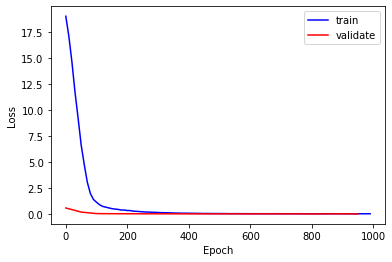

In [29]:
def train(save_model):
  n = 10
  m = 4
  dt = 0.01
  model = DynamicsNN(n, m, dt).cuda()

  lr = 1e-5
  optimizer = torch.optim.Adam(model.parameters(), lr)
  loss_fn = nn.MSELoss()

  epochs = 1000
  batch_size = 500
  data_gen = DataGenerator(n, m, dt, batch_size)

  save_every = 10
  decay_every = 100
  validate_every = 50

  epoch_hist = []
  loss_hist = []
  v_loss_hist = []
  v_epoch_hist = []

  num_nans = 0

  last_l = 0
  last_e = 0
  info = tqdm(total=epochs, position=0, leave=False)
  for epoch in range(epochs):
    optimizer.zero_grad()

    xu_t, x_tp1 = data_gen.getBatch()
    in_var = Variable(torch.from_numpy(xu_t).float(), requires_grad=True).cuda()
    out_truth = Variable(torch.from_numpy(x_tp1).float(), requires_grad=False).cuda()

    out_pred = model(in_var)

    loss = calcLoss(loss_fn, out_truth, out_pred)

    loss.backward()
    optimizer.step()

    # was getting nans in out_pred and loss because / by 0 in norm calculation 
    # until I removed ReLU from last layer
    loss = loss.item()
    if np.isnan(loss):
      num_nans += 1

    if epoch % validate_every == 0:
      v_loss_hist.append(validate(model, dt, optimizer, loss_fn))
      v_epoch_hist.append(epoch)

    if epoch % save_every == 0:
      last_l = loss
      epoch_hist.append(epoch)
      loss_hist.append(loss)
      if save_model:
        torch.save(model, 'learned_quadrotor_model.pt')
    
    if epoch % decay_every == 0:
      lr *= 0.9
      for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    info.set_description('Last saved loss: {:.3f}'.format(last_l))
    info.update(1)
  
  fig, ax = plt.subplots()
  train_losses, = ax.plot(epoch_hist, loss_hist, 'b', label='train')
  val_losses, = ax.plot(v_epoch_hist, v_loss_hist, 'r', label='validate')
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss')
  ax.legend()
  print('\nNans: ', num_nans)
  print('sample input: ', xu_t[0])
  print('true output: ', x_tp1[0])
  print('predicted output: ', out_pred[0])
  plt.show()

train(save_model=False)